In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import psycopg2

### Get the data

Connect to database and read files using `pandas.read_sql`. <br>
We get three tables: `users`, `posts` and `feed`. 
Assuming that `feed` could be too large, let's set up the limit.

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

False

#### Users

In [5]:
conn_uri = os.environ.get('DATABASE_URL')

users = pd.read_sql(
    "SELECT * FROM public.user_data",
    conn_uri
)
users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


We have the following information about users:
* user id 
* gender 
* age (indicted in profile)
* country (indicted in profile)
* city (indicted in profile)
* exp_group (experimental group: some encrypted category)
* os (the operating system of the device from which the social network is used)
* source (whether the user came to the app from organic traffic or from ads)

In [6]:
users.describe(include='all')

,user_id,gender,age,country,city,exp_group,os,source
count,163205.000000,163205.000000,163205.000000,163205,163205,163205.000000,163205,163205
unique,NaN,NaN,NaN,11,3915,NaN,2,2
top,NaN,NaN,NaN,Russia,Moscow,NaN,Android,ads
freq,NaN,NaN,NaN,143035,21874,NaN,105972,101685
mean,85070.371759,0.551331,27.195405,NaN,NaN,1.997598,NaN,NaN
std,48971.639950,0.497360,10.239158,NaN,NaN,1.413644,NaN,NaN
min,200.000000,0.000000,14.000000,NaN,NaN,0.000000,NaN,NaN
25%,41030.000000,0.000000,19.000000,NaN,NaN,1.000000,NaN,NaN
50%,85511.000000,1.000000,24.000000,NaN,NaN,2.000000,NaN,NaN
75%,127733.000000,1.000000,33.000000,NaN,NaN,3.000000,NaN,NaN


#### Posts

In [7]:
posts = pd.read_sql(
    "SELECT * FROM public.post_text_df",
    conn_uri
)
posts.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


We have the following information about posts:
* post id 
* text 
* topic (main subject)


In [8]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


In [9]:
feed = pd.read_sql(
    "SELECT * FROM public.feed_data limit 800000",
    conn_uri,
    parse_dates=['timestamp']
)

feed.head()

,timestamp,user_id,post_id,action,target
0,2021-12-22 08:07:11,150513,1297,view,1
1,2021-12-22 08:08:57,150513,1297,like,0
2,2021-12-22 08:08:59,150513,6831,view,0
3,2021-12-22 08:10:03,150513,4370,view,0
4,2021-12-22 08:12:28,150513,1410,view,0


In [10]:
n_users = len(feed.user_id.unique())
n_posts = len(feed.post_id.unique())
print(f'Number of unique users is {n_users}.')
print(f'Number of unique posts is {n_posts}.')
print(f'The full matrix will have {n_users * n_posts} elements.')
print('-----'*10)
print(f'Number of interactions is {feed.shape[0]}.')
print(f'Therefore, only {feed.shape[0] / (n_users * n_posts) * 100} % of matrix will be filled.')

Number of unique users is 1716.
Number of unique posts is 6831.
The full matrix will have 11721996 elements.
--------------------------------------------------
Number of interactions is 800000.
Therefore, only 6.824776258241344 % of matrix will be filled.


### Merge the dataframes 

Merging all the dataframes to get more information about users and posts. Probably, we will need this.

In [11]:
df = pd.merge(
    feed,
    users,
    on='user_id',
    how='left'
)

df.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source
0,2021-12-22 08:07:11,150513,1297,view,1,1,21,Russia,Tyumen,1,iOS,organic
1,2021-12-22 08:08:57,150513,1297,like,0,1,21,Russia,Tyumen,1,iOS,organic
2,2021-12-22 08:08:59,150513,6831,view,0,1,21,Russia,Tyumen,1,iOS,organic
3,2021-12-22 08:10:03,150513,4370,view,0,1,21,Russia,Tyumen,1,iOS,organic
4,2021-12-22 08:12:28,150513,1410,view,0,1,21,Russia,Tyumen,1,iOS,organic


In [12]:
df = pd.merge(
    df,
    posts,
    on='post_id',
    how='left'
)

df.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-12-22 08:07:11,150513,1297,view,1,1,21,Russia,Tyumen,1,iOS,organic,Could rivalry overshadow election?\n\nTony Bla...,politics
1,2021-12-22 08:08:57,150513,1297,like,0,1,21,Russia,Tyumen,1,iOS,organic,Could rivalry overshadow election?\n\nTony Bla...,politics
2,2021-12-22 08:08:59,150513,6831,view,0,1,21,Russia,Tyumen,1,iOS,organic,"This is the epitome of bad 80s film-making, un...",movie
3,2021-12-22 08:10:03,150513,4370,view,0,1,21,Russia,Tyumen,1,iOS,organic,This movie promised bat people. It didnt deliv...,movie
4,2021-12-22 08:12:28,150513,1410,view,0,1,21,Russia,Tyumen,1,iOS,organic,Soderling wins tense Milan final\n\nFifth seed...,sport


### EDA part

#### Distribution in each category
First, let's see the distribution of unique types in each category.

In [13]:
countries_dict = {}
for country in df.country.unique():
    countries_dict[country] = sum(df.country == country)

country_freq = {k: v for k, v in sorted(countries_dict.items(), key=lambda item: item[1])}
for key, value in country_freq.items():
    print(f'{key} = {value}')

Latvia = 260
Cyprus = 476
Estonia = 1387
Switzerland = 1759
Finland = 4184
Azerbaijan = 7071
Turkey = 8603
Kazakhstan = 13458
Belarus = 16480
Ukraine = 43180
Russia = 703142


Most users are from Russia but still there are some users from other countries. Let's keep this data.

In [14]:
city_dict = {}
for city in df.city.unique():
    city_dict[city] = sum(df.city == city)

city_freq = {k: v for k, v in sorted(city_dict.items(), key=lambda item: item[1])}
for key, value in city_freq.items():
    print(f'{key} = {value}')

Kaltan = 109
Zasechnoye = 131
Kaspiyskiy = 145
Birsk = 152
Murmansk = 153
Moskovskiy = 154
Baley = 157
Yakshur-Bod’ya = 158
Kirovsk = 159
Borova = 160
Starosubkhangulovo = 160
Myski = 162
Khryashchevka = 168
Poltava = 169
Chermen = 170
Qostanay = 170
Divnoye = 171
Pochëp = 173
Lakha Nëvre = 174
Dovzhansk = 177
Kolchugino = 182
Snezhinsk = 183
Viljandi = 183
Sorochinsk = 183
Arsenyev = 183
Asipovichy = 187
Mariinsk = 188
Chokurdakh = 189
Novopavlovsk = 193
Yaransk = 193
Makiivka = 195
Yoshkar-Ola = 196
Lerik = 196
Otradnyy = 197
Gryazovets = 198
Chukhloma = 198
Prokopyevsk = 199
Fontanka = 200
Achinsk = 201
Ladyzhyn = 201
Udelnaya = 202
Budënnovsk = 205
Troitskoye = 210
Ternopil = 210
Rayevskiy = 216
Lesnoy = 217
Murom = 220
Navapolatsk = 222
Malmyzh = 223
Apatity = 224
Zhigulevsk = 225
Vaasa = 225
Krasnokamsk = 225
Rubtsovsk = 227
Kola = 228
Podilsk = 231
Sosnovyy Bor = 232
Yur’yev-Pol’skiy = 236
Gornozavodsk = 241
Vyazniki = 242
Starodub = 244
Kudymkar = 245
Malaya Purga = 249
Aleksin

In [15]:
topic_dict = {}
for topic in df.topic.unique():
    topic_dict[topic] = sum(df.topic == topic)

topic_dict = {k: v for k, v in sorted(topic_dict.items(), key=lambda item: item[1])}
for key, value in topic_dict.items():
    print(f'{key} = {value}')

tech = 32085
entertainment = 40398
business = 49893
politics = 80846
sport = 106973
covid = 193763
movie = 296042


Each topic is well presented in data. However, the most common topics are 'movie', 'covid' and 'sport'.

In [22]:
source_dict = {}
for source in df.source.unique():
    topic_dict[source] = sum(df.source == source)

source_dict = {k: v for k, v in sorted(source_dict.items(), key=lambda item: item[1])}
for key, value in source_dict.items():
    print(f'{key} = {value}')

In [23]:
age_dict = {}
for age in df.age.unique():
    age_dict[age] = sum(df.age == age)

age_dict = {k: v for k, v in sorted(age_dict.items(), key=lambda item: item[1])}
for key, value in age_dict.items():
    print(f'{key} = {value}')

66 = 154
60 = 166
64 = 209
58 = 456
61 = 547
62 = 708
57 = 870
65 = 980
68 = 1157
59 = 1168
70 = 1291
49 = 2641
55 = 2647
56 = 2854
52 = 3555
53 = 4608
54 = 5211
50 = 5641
46 = 6352
51 = 7024
48 = 7278
42 = 7621
47 = 7797
44 = 7961
39 = 8279
45 = 8497
43 = 9793
40 = 10986
34 = 11100
41 = 11415
37 = 13498
38 = 13529
14 = 14256
30 = 16097
35 = 16892
36 = 17285
33 = 17896
31 = 19273
32 = 19781
26 = 20727
29 = 21034
15 = 21055
28 = 23007
25 = 26402
27 = 27971
16 = 28321
24 = 28933
18 = 39664
17 = 39924
22 = 40729
23 = 41286
21 = 46787
19 = 49711
20 = 56976


In [24]:
ages = []
for age in age_dict.keys():
    ages.append(age)
print(sorted(ages))

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 70]


In [19]:
group_dict = {}
for group in df.exp_group.unique():
    group_dict[group] = sum(df.exp_group == group)

group_dict = {k: v for k, v in sorted(group_dict.items(), key=lambda item: item[1])}
for key, value in group_dict.items():
    print(f'{key} = {value}')

0 = 143292
3 = 156118
2 = 159629
4 = 160024
1 = 180937


In [20]:
os_dict = {}
for os in df.os.unique():
    os_dict[os] = sum(df.os == os)

os_dict = {k: v for k, v in sorted(os_dict.items(), key=lambda item: item[1])}
for key, value in os_dict.items():
    print(f'{key} = {value}')

iOS = 287181
Android = 512819


In [21]:
gender_dict = {}
for gender in df.gender.unique():
    gender_dict[gender] = sum(df.gender == gender)

gender_dict = {k: v for k, v in sorted(gender_dict.items(), key=lambda item: item[1])}
for key, value in gender_dict.items():
    print(f'{key} = {value}')

0 = 350608
1 = 449392


It seems like all the categories could give useful information for future model.

#### Visual distribution of activity types between categories
Let's see if some types of users are more into liking posts or some types of posts are more likely to be liked.

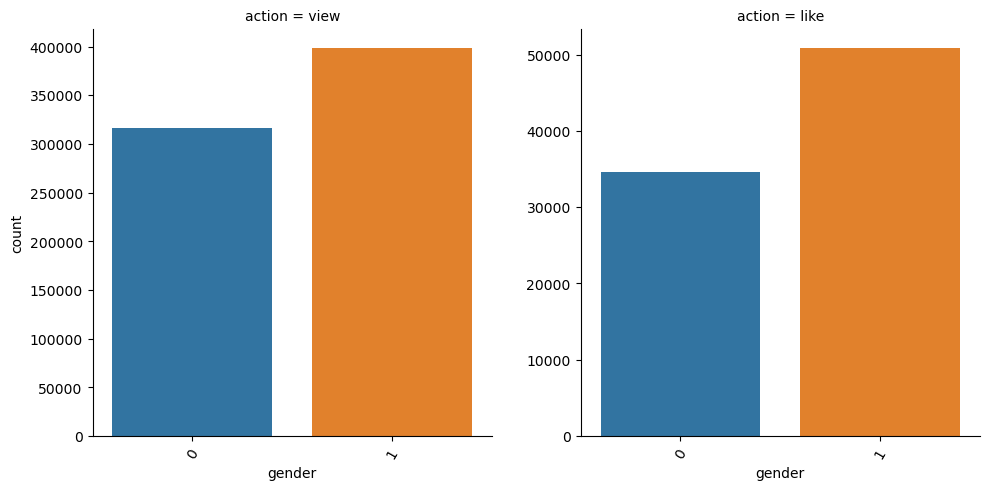

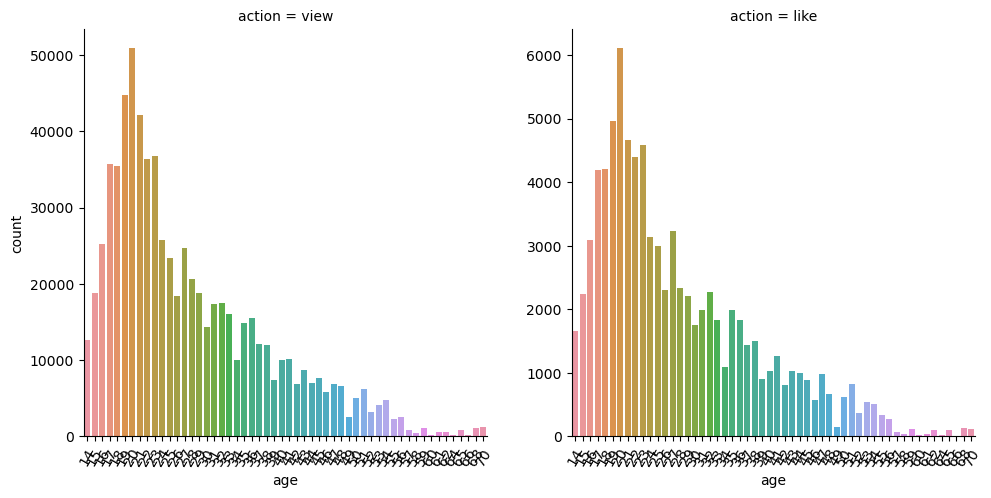

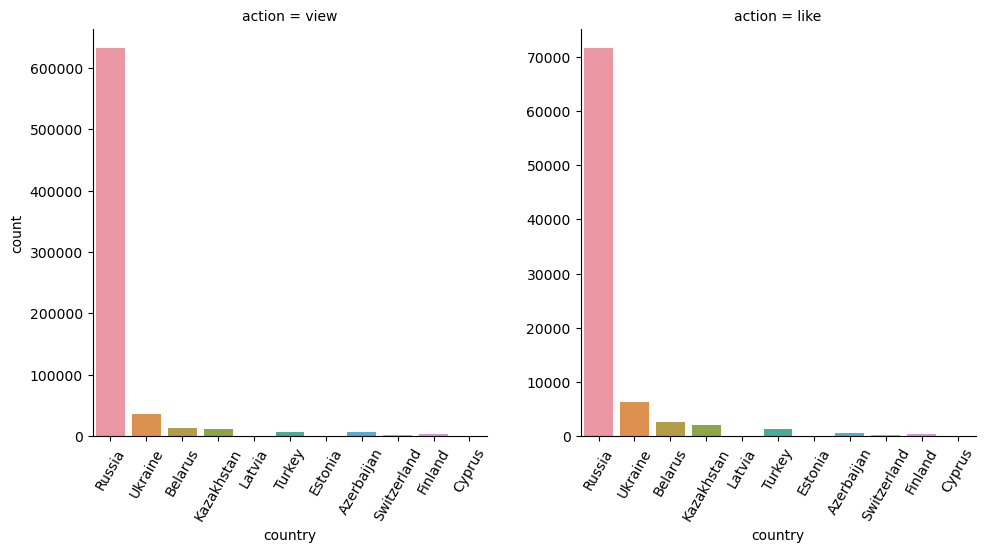

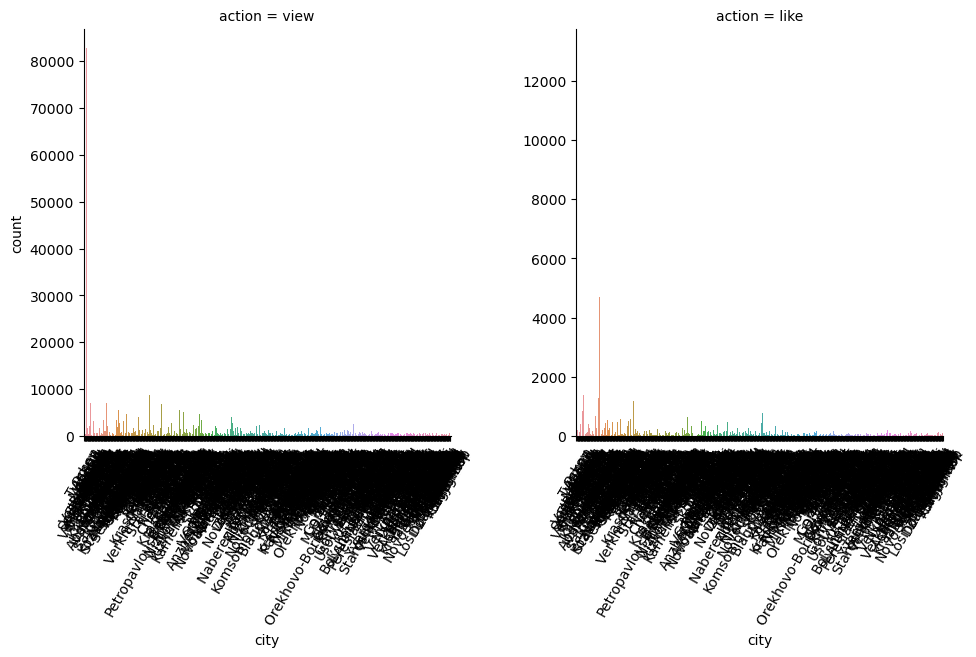

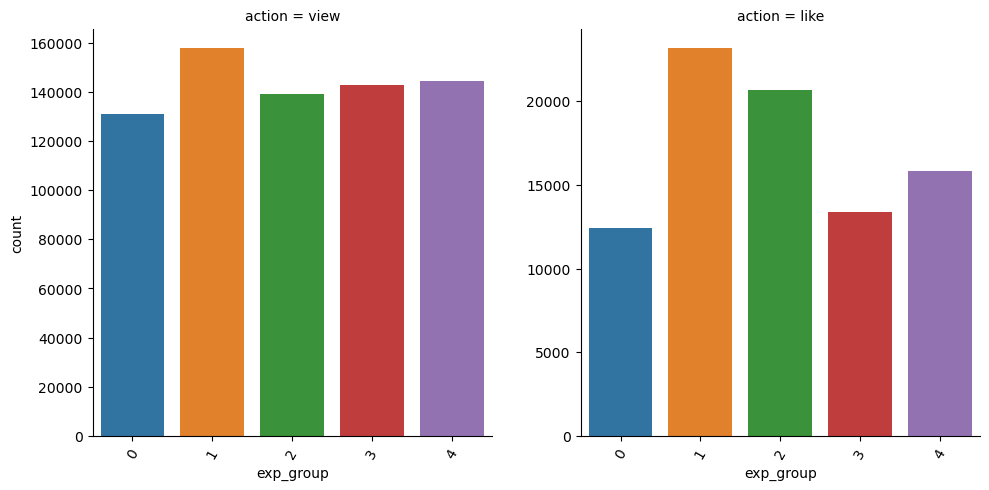

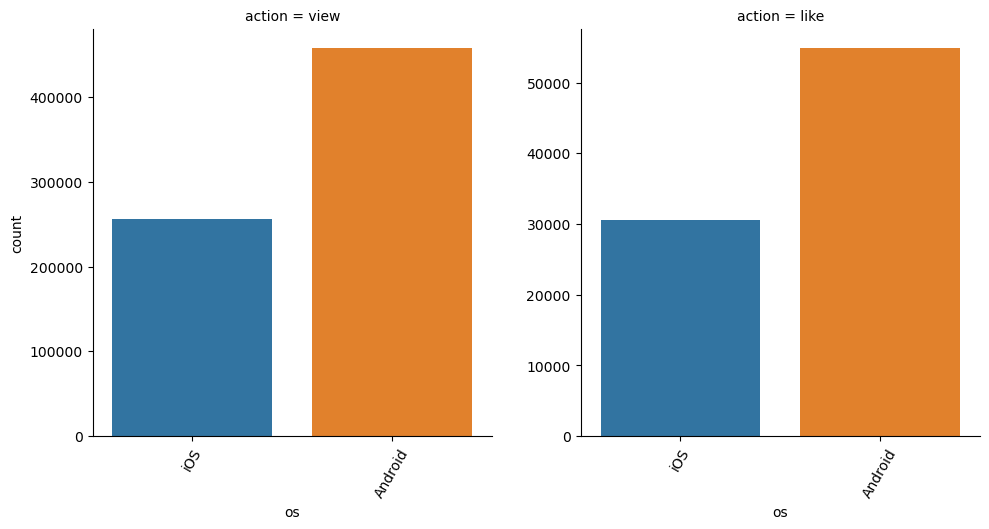

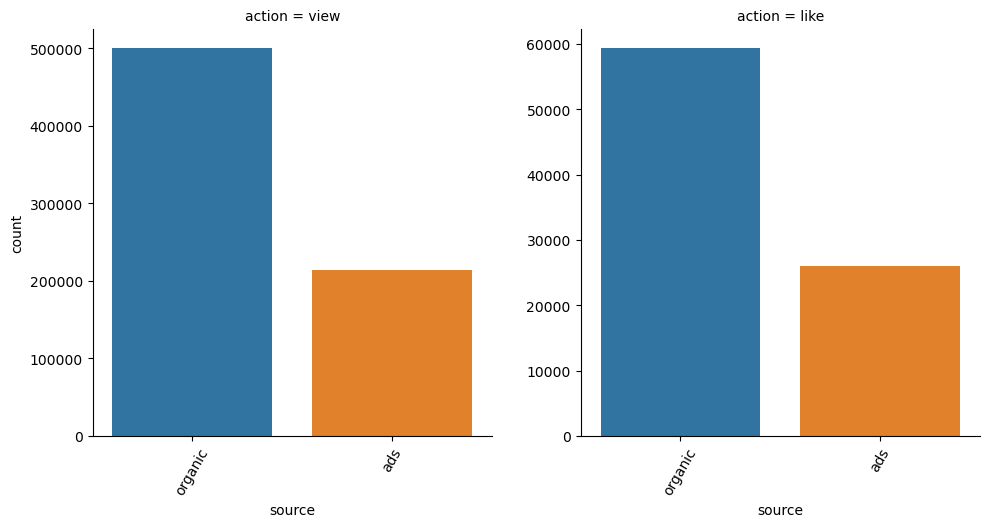

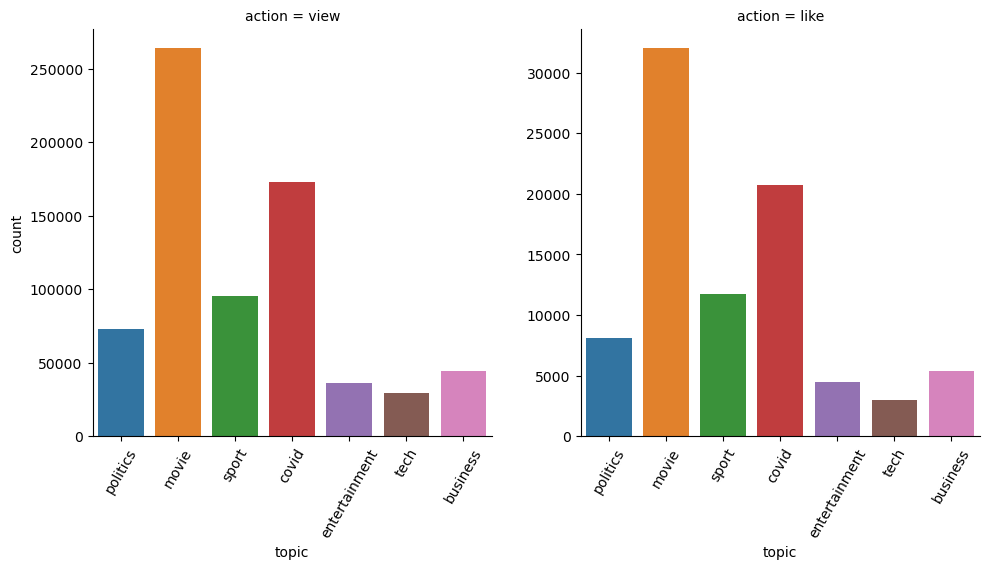

In [25]:
import seaborn as sns

check_cols = ['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'topic']
for col in check_cols:
    g = sns.catplot(x=col, kind='count', col='action', data=df, sharey=False)
    g.set_xticklabels(rotation=60)
plt.show()

### Set the real target

Let's start with Target understanding.

We'll use only `feed` table. In this case it will be reasonable to devide data into train and validation part by time.

In [26]:
feed_data = feed.sort_values("timestamp")

train_feed = feed_data.iloc[:-560000].copy()
test_feed = feed_data.iloc[-560000:].copy()

In [27]:
feed_data.head()

,timestamp,user_id,post_id,action,target
188467,2021-10-01 06:02:14,157193,1621,view,0
188468,2021-10-01 06:02:31,157193,972,view,0
188469,2021-10-01 06:03:15,157193,293,view,0
188470,2021-10-01 06:05:39,157193,3939,view,0
149944,2021-10-01 06:06:44,118129,7085,view,0


Let's get our `target` column which shows whether the user was interested in the post or not.
We'll assume that the user was actually interested if he put `like` right after he viewed the post or if he at least put a `like` anyways.
All other cases show that he ignored the post.
Let's call this column `true_target`.

In [28]:
def was_ignored_or_liked(row):
    
    if row['action'] == 'view':
        if row['target'] == 1:
            return 1
        else:
            return 0
    elif row['action'] == 'like':
        return 1
    else:
        return 'unknown'

train_feed['true_target'] = train_feed.apply(was_ignored_or_liked, axis=1)
train_feed

,timestamp,user_id,post_id,action,target,true_target
188467,2021-10-01 06:02:14,157193,1621,view,0,0
188468,2021-10-01 06:02:31,157193,972,view,0,0
188469,2021-10-01 06:03:15,157193,293,view,0,0
188470,2021-10-01 06:05:39,157193,3939,view,0,0
149944,2021-10-01 06:06:44,118129,7085,view,0,0
...,...,...,...,...,...,...
744933,2021-10-29 10:44:57,54718,4380,view,0,0
93563,2021-10-29 10:45:00,46002,5004,view,0,0
642592,2021-10-29 10:45:02,131242,4144,view,0,0
755325,2021-10-29 10:45:07,118217,6193,view,0,0


### Feature engeneering

#### Posts
It seems that some of the posts can be more popular than the other ones. We can find out users' preferences analysing historical data to make a new feature.
The idea is the following: let's calculate the part of likes for each post in `feed`. For all the posts we will get a number which represents its popularity. For all the posts that we do not have any info in `feed` we fill in NaN values with 0.

In [30]:
# calculate the count of each action for each post
action_counts = feed.groupby(['post_id', 'action']).size().unstack(fill_value=0)

# calculate the part of likes (number of likes divided by the number of views)
action_counts['part_of_likes'] = action_counts['like'] / action_counts['view']


# join the part_of_likes column to the original posts dataframe
posts = posts.join(action_counts['part_of_likes'], on='post_id')

# fill NA values with the mean
posts['part_of_likes'].fillna(0, inplace=True)
posts.head()

,post_id,text,topic,part_of_likes
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.172043
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.062500
2,3,Asian quake hits European shares\n\nShares in ...,business,0.107143
3,4,India power shares jump on debut\n\nShares in ...,business,0.127907
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.076087


The next idea is to create a new feature such as text lenght. Some users prefer longreads, some of them prefer short notes.<br>

Also let's make a transformer to transform user_info and post_info into features that we'll need.

In [31]:
posts['text_lenght'] = posts['text'].str.len().astype(int)
posts.head()

,post_id,text,topic,part_of_likes,text_lenght
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.172043,1967
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.062500,2701
2,3,Asian quake hits European shares\n\nShares in ...,business,0.107143,3408
3,4,India power shares jump on debut\n\nShares in ...,business,0.127907,1026
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.076087,889


The next idea is to get embeddings for the texts and devide the posts into three clusters (because of the visual representation).

In [ ]:
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import BertModel
from transformers import DataCollatorWithPadding
from transformers import DistilBertModel
from transformers import RobertaModel

In [ ]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']

    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }

    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }

    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [ ]:
# I use bert as an advanced model showing best results

tokenizer, model = get_model('bert')

In [ ]:
# Make a dataloader for posts

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
dataset = PostDataset(posts['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

In [ ]:
import torch
from tqdm import tqdm

@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [ ]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings

Now when we have embeddings we can devide the posts into 3 classes. I used to make different number of classes (up to 10) but visually it seems to be 3. Check out the plot below.

In [ ]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3)

# Fitting the model to our embeddings
kmeans_model.fit(embeddings)

# Getting the cluster labels for each of the texts (each embedding)
cluster_labels = kmeans_model.labels_

# Assign these cluster labels back to the original dataframe
posts['cluster'] = cluster_labels

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters of Posts')
plt.colorbar()
plt.show()

We can also keep some information about text using tf-idf and applying 'mean' above it.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(posts['text'])
avg_tfidf_scores = tfidf_matrix.mean(axis=1)
posts['avg_tfidf'] = avg_tfidf_scores
posts = posts.drop('text', axis = 1)

I won't make all these steps again and just download the resulting df with posts from database that I made for this project.

In [32]:
new_post_table = pd.read_sql(
    "SELECT * FROM public.v_elp_posts_with_clusters",
    conn_uri
)
new_post_table.head()

,post_id,cluster,avg_tfidf,part_of_likes,topic,text_lenght
0,1,3,0.000204,0.122222,business,1967
1,2,1,0.000261,0.113924,business,2701
2,3,1,0.000275,0.094118,business,3408
3,4,1,0.000153,0.123596,business,1026
4,5,1,0.000149,0.168675,business,889


#### Users
We can also extract some more information out of the `users` table.
First of all we can devide all the users into age groups based on psycological differences.

In [33]:
# Copy the table just in case
copy_users = users.copy()
copy_users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [35]:
 def age_categorizer(row):
        schoolers = 13 < row['age'] < 18 
        adolescents = 18 <= row['age'] < 24
        young = 24 <= row['age'] < 35 
        grown_ups = 35 <= row['age'] < 60
        wise =60 <= row['age']

        if schoolers:
            return 'schooler'
        elif adolescents:
            return 'adolescent'
        elif young:
            return 'young'
        elif grown_ups:
            return'grown_up'
        elif wise:
            return 'wise'
        else:
            return 'unknown'
    
copy_users['age_group'] = copy_users.apply(age_categorizer, axis=1)
copy_users.head()

,user_id,gender,age,country,city,exp_group,os,source,age_group
0,200,1,34,Russia,Degtyarsk,3,Android,ads,young
1,201,0,37,Russia,Abakan,0,Android,ads,grown_up
2,202,1,17,Russia,Smolensk,4,Android,ads,schooler
3,203,0,18,Russia,Moscow,1,iOS,ads,adolescent
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,grown_up


Also we assume that the status of the city can also be important. Let's get a new column with boolean value showing if the city is a capital city.<br>
We already know all the unique countries and we can get their capital cities.

In [36]:
def is_capital(row):
    capital_cities = {
            'Switzerland': 'Bern',
            'Cyprus': 'Nicosia',
            'Latvia': 'Riga',
            'Estonia': 'Tallinn',
            'Finland': 'Helsinki',
            'Belarus': 'Minsk',
            'Kazakhstan': 'Nur-Sultan',
            'Azerbaijan': 'Baku',
            'Turkey': 'Ankara',
            'Ukraine': 'Kyiv',
            'Russia': 'Moscow'
        }
    return 1 if capital_cities[row['country']] == row['city'] else 0

copy_users['is_capital'] = copy_users.apply(is_capital, axis=1)

In [37]:
copy_users = copy_users.drop('age', axis = 1)
copy_users.head()

,user_id,gender,country,city,exp_group,os,source,age_group,is_capital
0,200,1,Russia,Degtyarsk,3,Android,ads,young,0
1,201,0,Russia,Abakan,0,Android,ads,grown_up,0
2,202,1,Russia,Smolensk,4,Android,ads,schooler,0
3,203,0,Russia,Moscow,1,iOS,ads,adolescent,1
4,204,0,Russia,Anzhero-Sudzhensk,3,Android,ads,grown_up,0


### Training the model

In [53]:
# Merge feed and users
df = pd.merge(
    feed,
    copy_users,
    on='user_id',
    how='left'
)

# Now this df and new posts
df = pd.merge(
    df,
    new_post_table,
    on='post_id',
    how='left'
)

# Add true target
df_with_real_target = df.copy()
df_with_real_target['true_target'] = df_with_real_target.apply(was_ignored_or_liked, axis=1)

# Set index back and get rid of the duplicates
df_with_real_target = df_with_real_target.set_index(["user_id", "post_id"])
df_with_real_target = df_with_real_target.loc[~df_with_real_target.index.duplicated(keep='first')]

# Learn the shape and devide data
df_shape = df_with_real_target.shape[0]
split_point = round(df_shape * 0.7)
data = df_with_real_target.sort_values("timestamp")

train_data = data.iloc[:-split_point].copy()
test_data = data.iloc[-split_point:].copy()

In [54]:
train_data.head()

timestamp action  target  gender country   city  \
user_id post_id                                                             
157193  1621    2021-10-01 06:02:14   view       0       0  Russia   Tula   
        972     2021-10-01 06:02:31   view       0       0  Russia   Tula   
        293     2021-10-01 06:03:15   view       0       0  Russia   Tula   
        3939    2021-10-01 06:05:39   view       0       0  Russia   Tula   
118129  7085    2021-10-01 06:06:44   view       0       0  Russia  Kansk   

                 exp_group       os   source   age_group  is_capital  cluster  \
user_id post_id                                                                 
157193  1621             3  Android  organic  adolescent           0        3   
        972              3  Android  organic  adolescent           0        1   
        293              3  Android  organic  adolescent           0        1   
        3939             3  Android  organic  adolescent           0        2   
118129  7085             1  Android  organic    grown_up           0        0   

                 avg_tfidf  part_of_likes     topic  text_lenght  true_target  
user_id post_id                                                                
157193  1621      0.000225       0.148325     sport         2177            0  
        972       0.000253       0.100000  politics         4156            0  
        293       0.000246       0.157895  business         2583            0  
        3939      0.000070       0.189189     covid          140            0  
118129  7085      0.000179       0.087719     movie          935            0

In [56]:
negative_class = len(train_data[train_data.true_target==0])
positive_class = len(train_data[train_data.true_target==1])
print(f"There are {negative_class} objects of negative class")
print(f"There are only {positive_class} objects of positive class")

There are 185211 objects of negative class
There are only 19275 objects of positive class


The data is imbalanced and we should keep it in mind while training the model.

In [57]:
train_target = train_data['true_target'] 
train_data = train_data.drop(['true_target', 'action', 'target', 'timestamp'], axis = 1)

In [58]:
test_target = test_data['true_target'] 
test_data = test_data.drop(['true_target', 'action', 'target', 'timestamp'], axis = 1)

In [59]:
test_data = test_data.drop('city', axis = 1)
train_data = train_data.drop('city', axis = 1)

In [60]:
train_data.head()

gender country  exp_group       os   source   age_group  \
user_id post_id                                                            
157193  1621          0  Russia          3  Android  organic  adolescent   
        972           0  Russia          3  Android  organic  adolescent   
        293           0  Russia          3  Android  organic  adolescent   
        3939          0  Russia          3  Android  organic  adolescent   
118129  7085          0  Russia          1  Android  organic    grown_up   

                 is_capital  cluster  avg_tfidf  part_of_likes     topic  \
user_id post_id                                                            
157193  1621              0        3   0.000225       0.148325     sport   
        972               0        1   0.000253       0.100000  politics   
        293               0        1   0.000246       0.157895  business   
        3939              0        2   0.000070       0.189189     covid   
118129  7085              0        0   0.000179       0.087719     movie   

                 text_lenght  
user_id post_id               
157193  1621            2177  
        972             4156  
        293             2583  
        3939             140  
118129  7085             935

Select all object columns

In [61]:
object_cols = ['gender', 'country', 'os', 'source', 'age_group', 'is_capital', 'cluster','topic']

I've tried different models and CatBoost showed the best result on test data.
The weights are initialized so that we could deal with imbalanced classes.

In [62]:
from catboost import CatBoostClassifier

cat_classifier = CatBoostClassifier(iterations=700,
                                    learning_rate=0.4,
                                   class_weights=[0.5, 1.4])

cat_classifier.fit(train_data, train_target, cat_features=object_cols)

0:	learn: 0.5847275	total: 1.4s	remaining: 16m 20s
1:	learn: 0.5453241	total: 2.61s	remaining: 15m 11s
2:	learn: 0.5293898	total: 3.49s	remaining: 13m 31s
3:	learn: 0.5240675	total: 4.14s	remaining: 12m
4:	learn: 0.5203287	total: 4.75s	remaining: 11m
5:	learn: 0.5196910	total: 5.04s	remaining: 9m 42s
6:	learn: 0.5159785	total: 5.64s	remaining: 9m 18s
7:	learn: 0.5134653	total: 6.35s	remaining: 9m 9s
8:	learn: 0.5102746	total: 6.87s	remaining: 8m 47s
9:	learn: 0.5100083	total: 7.38s	remaining: 8m 29s
10:	learn: 0.5090269	total: 8.04s	remaining: 8m 23s
11:	learn: 0.5085844	total: 8.75s	remaining: 8m 21s
12:	learn: 0.5082101	total: 9.35s	remaining: 8m 14s
13:	learn: 0.5079745	total: 9.96s	remaining: 8m 8s
14:	learn: 0.5072831	total: 10.6s	remaining: 8m 1s
15:	learn: 0.5069591	total: 11.1s	remaining: 7m 53s
16:	learn: 0.5066224	total: 11.7s	remaining: 7m 50s
17:	learn: 0.5063831	total: 12.3s	remaining: 7m 45s
18:	learn: 0.5063263	total: 12.9s	remaining: 7m 44s
19:	learn: 0.5062429	total: 1

157:	learn: 0.4852845	total: 1m 50s	remaining: 6m 18s
158:	learn: 0.4851150	total: 1m 50s	remaining: 6m 17s
159:	learn: 0.4850858	total: 1m 51s	remaining: 6m 17s
160:	learn: 0.4850742	total: 1m 52s	remaining: 6m 16s
161:	learn: 0.4849698	total: 1m 52s	remaining: 6m 15s
162:	learn: 0.4849032	total: 1m 53s	remaining: 6m 14s
163:	learn: 0.4847385	total: 1m 54s	remaining: 6m 13s
164:	learn: 0.4845769	total: 1m 54s	remaining: 6m 12s
165:	learn: 0.4845064	total: 1m 55s	remaining: 6m 12s
166:	learn: 0.4844426	total: 1m 56s	remaining: 6m 11s
167:	learn: 0.4843271	total: 1m 57s	remaining: 6m 10s
168:	learn: 0.4842289	total: 1m 57s	remaining: 6m 10s
169:	learn: 0.4841675	total: 1m 58s	remaining: 6m 9s
170:	learn: 0.4841217	total: 1m 59s	remaining: 6m 9s
171:	learn: 0.4839825	total: 2m	remaining: 6m 8s
172:	learn: 0.4839301	total: 2m	remaining: 6m 8s
173:	learn: 0.4838085	total: 2m 1s	remaining: 6m 7s
174:	learn: 0.4837894	total: 2m 2s	remaining: 6m 7s
175:	learn: 0.4837086	total: 2m 3s	remaining

311:	learn: 0.4696844	total: 3m 51s	remaining: 4m 47s
312:	learn: 0.4695374	total: 3m 51s	remaining: 4m 46s
313:	learn: 0.4693926	total: 3m 52s	remaining: 4m 45s
314:	learn: 0.4693059	total: 3m 52s	remaining: 4m 44s
315:	learn: 0.4691513	total: 3m 53s	remaining: 4m 43s
316:	learn: 0.4690185	total: 3m 54s	remaining: 4m 42s
317:	learn: 0.4688343	total: 3m 54s	remaining: 4m 42s
318:	learn: 0.4687002	total: 3m 55s	remaining: 4m 41s
319:	learn: 0.4686388	total: 3m 56s	remaining: 4m 40s
320:	learn: 0.4685457	total: 3m 56s	remaining: 4m 39s
321:	learn: 0.4684489	total: 3m 57s	remaining: 4m 38s
322:	learn: 0.4683043	total: 3m 58s	remaining: 4m 38s
323:	learn: 0.4681253	total: 3m 58s	remaining: 4m 37s
324:	learn: 0.4680095	total: 3m 59s	remaining: 4m 36s
325:	learn: 0.4678210	total: 4m	remaining: 4m 35s
326:	learn: 0.4677209	total: 4m	remaining: 4m 34s
327:	learn: 0.4675471	total: 4m 1s	remaining: 4m 33s
328:	learn: 0.4674820	total: 4m 2s	remaining: 4m 33s
329:	learn: 0.4674006	total: 4m 3s	rem

465:	learn: 0.4545049	total: 5m 37s	remaining: 2m 49s
466:	learn: 0.4544006	total: 5m 38s	remaining: 2m 48s
467:	learn: 0.4543496	total: 5m 39s	remaining: 2m 48s
468:	learn: 0.4542481	total: 5m 39s	remaining: 2m 47s
469:	learn: 0.4541280	total: 5m 40s	remaining: 2m 46s
470:	learn: 0.4540492	total: 5m 41s	remaining: 2m 45s
471:	learn: 0.4540018	total: 5m 41s	remaining: 2m 45s
472:	learn: 0.4539076	total: 5m 42s	remaining: 2m 44s
473:	learn: 0.4538420	total: 5m 43s	remaining: 2m 43s
474:	learn: 0.4537104	total: 5m 43s	remaining: 2m 42s
475:	learn: 0.4535967	total: 5m 44s	remaining: 2m 42s
476:	learn: 0.4535723	total: 5m 44s	remaining: 2m 41s
477:	learn: 0.4534682	total: 5m 45s	remaining: 2m 40s
478:	learn: 0.4534033	total: 5m 46s	remaining: 2m 39s
479:	learn: 0.4533598	total: 5m 46s	remaining: 2m 39s
480:	learn: 0.4532905	total: 5m 47s	remaining: 2m 38s
481:	learn: 0.4531990	total: 5m 48s	remaining: 2m 37s
482:	learn: 0.4530212	total: 5m 48s	remaining: 2m 36s
483:	learn: 0.4529473	total:

619:	learn: 0.4423210	total: 7m 20s	remaining: 56.9s
620:	learn: 0.4423055	total: 7m 21s	remaining: 56.2s
621:	learn: 0.4421935	total: 7m 22s	remaining: 55.5s
622:	learn: 0.4420700	total: 7m 22s	remaining: 54.7s
623:	learn: 0.4419007	total: 7m 23s	remaining: 54s
624:	learn: 0.4418322	total: 7m 24s	remaining: 53.3s
625:	learn: 0.4417769	total: 7m 24s	remaining: 52.6s
626:	learn: 0.4417201	total: 7m 25s	remaining: 51.9s
627:	learn: 0.4416463	total: 7m 26s	remaining: 51.2s
628:	learn: 0.4415755	total: 7m 26s	remaining: 50.4s
629:	learn: 0.4414159	total: 7m 27s	remaining: 49.7s
630:	learn: 0.4413497	total: 7m 28s	remaining: 49s
631:	learn: 0.4412616	total: 7m 28s	remaining: 48.3s
632:	learn: 0.4412048	total: 7m 29s	remaining: 47.6s
633:	learn: 0.4411235	total: 7m 30s	remaining: 46.9s
634:	learn: 0.4410594	total: 7m 30s	remaining: 46.1s
635:	learn: 0.4409902	total: 7m 31s	remaining: 45.5s
636:	learn: 0.4409130	total: 7m 32s	remaining: 44.8s
637:	learn: 0.4408475	total: 7m 33s	remaining: 44.

### Metrics

In [64]:
from sklearn.metrics import f1_score

cat_preds = cat_classifier.predict(test_data)

f1_score(test_target, cat_preds, average='weighted')

0.8124319698957903

In [66]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(test_target, cat_preds)

0.509637968942611

In [67]:
from sklearn.metrics import recall_score

recall_score(test_target, cat_preds, average='weighted')

0.8590710366479857

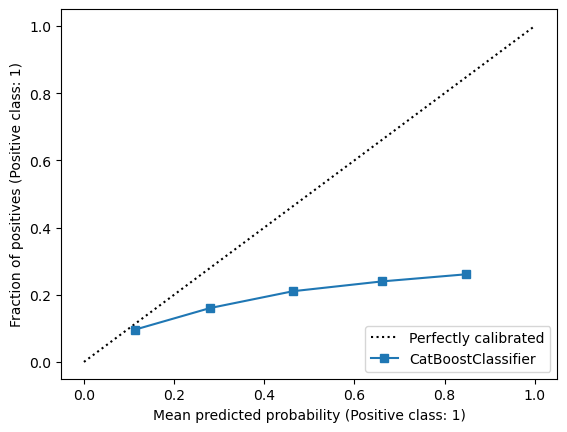

In [68]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(cat_classifier, test_data, test_target)
plt.show()

The model shows pretty good result. It has relatively high recall (especially considering class imbalance). And that is the reason why the model is too confident (which Calibration Display shows).

In [69]:
cat_classifier.save_model('model')